In [147]:
import pandas as pd
import numpy as np
import pickle

import os
from PIL import Image

import torch
import torch.nn as nn
from torchvision.io import read_image, ImageReadMode, sho
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import trange, tqdm

import random

from transformers import BertTokenizer, AutoTokenizer

In [133]:
with open('../csv/word2idx.pickle', 'rb') as file:
    word2idx = pickle.load(file)
    
word2idx['<pad>']=len(word2idx)
word2idx['<unk>']=len(word2idx)
len(word2idx)

2689

In [134]:
idx2word = {v:k for k, v in word2idx.items()}
len(idx2word)

2689

In [135]:
df = pd.read_pickle('../csv/generating_training_df.pickle')
df.columns

Index(['patch_paths_x', 'pid', 'cluster_assignment', 'complete_tokens',
       'dtype', 'notes'],
      dtype='object')

In [136]:
df.columns = ['patch_paths', 'pid', 'cluster_assignment', 'complete_tokens','dtype', 'notes']
df.head()

,patch_paths,pid,cluster_assignment,complete_tokens,dtype,notes
0,/project/GutIntelligenceLab/ss4yd/gtex_data/pr...,GTEX-R55E-1726,4,"[2, pieces, 5x7, mm, broken, apart, good, morp...",train,2 pieces ~9.5x7 mm; 1 broken apart; good morph...
1,/project/GutIntelligenceLab/ss4yd/gtex_data/pr...,GTEX-R55E-1726,4,"[2, pieces, 5x7, mm, broken, apart, good, morp...",train,2 pieces ~9.5x7 mm; 1 broken apart; good morph...
2,/project/GutIntelligenceLab/ss4yd/gtex_data/pr...,GTEX-R55E-1726,4,"[2, pieces, 5x7, mm, broken, apart, good, morp...",train,2 pieces ~9.5x7 mm; 1 broken apart; good morph...
3,/project/GutIntelligenceLab/ss4yd/gtex_data/pr...,GTEX-R55E-1726,4,"[2, pieces, 5x7, mm, broken, apart, good, morp...",train,2 pieces ~9.5x7 mm; 1 broken apart; good morph...
4,/project/GutIntelligenceLab/ss4yd/gtex_data/pr...,GTEX-R55E-1726,4,"[2, pieces, 5x7, mm, broken, apart, good, morp...",train,2 pieces ~9.5x7 mm; 1 broken apart; good morph...


In [138]:
# df=df.set_index(['pid','cluster_assignment'])
# df

In [139]:
pid_batch_size=8
img_per_pid=8
num_cluster=8

In [140]:
unique_pids=pd.unique(df.pid)
batches = [unique_pids[i:i+pid_batch_size] for i in pid_batch_size*np.arange(0, len(unique_pids)//pid_batch_size+1, 1)]
len(unique_pids)

385

In [141]:
random.shuffle(unique_pids)

In [142]:
unique_pids

array(['GTEX-T6MO-0226', 'GTEX-13NZ9-1226', 'GTEX-NPJ8-1226',
       'GTEX-13NZ8-1626', 'GTEX-14PKV-0826', 'GTEX-17MFQ-1326',
       'GTEX-POMQ-0526', 'GTEX-1OFPY-0326', 'GTEX-11ILO-0526',
       'GTEX-12C56-0526', 'GTEX-1LH75-0426', 'GTEX-17F97-2426',
       'GTEX-1HC8U-0326', 'GTEX-13111-1726', 'GTEX-111YS-2126',
       'GTEX-ZYFG-0426', 'GTEX-139YR-0726', 'GTEX-1IKOE-1026',
       'GTEX-1RAZS-0926', 'GTEX-139TS-1426', 'GTEX-17F9E-0726',
       'GTEX-X4XX-1126', 'GTEX-XMD1-0426', 'GTEX-144FL-1026',
       'GTEX-1OFPY-1726', 'GTEX-12696-1226', 'GTEX-1PPGY-1826',
       'GTEX-1RQED-1326', 'GTEX-14PJ6-0726', 'GTEX-1JMLX-1826',
       'GTEX-Y5V5-0626', 'GTEX-18D9B-0126', 'GTEX-WVLH-2926',
       'GTEX-17HHE-0626', 'GTEX-15SHU-1826', 'GTEX-13FLW-2626',
       'GTEX-1QCLZ-0626', 'GTEX-XMD2-0426', 'GTEX-17EVQ-1526',
       'GTEX-1445S-1326', 'GTEX-1I1GU-0726', 'GTEX-1I1CD-2226',
       'GTEX-QDT8-1026', 'GTEX-1192W-0726', 'GTEX-17JCI-1526',
       'GTEX-1B933-1226', 'GTEX-16YQH-1626', 'GTEX

In [148]:
class WSIBatchedDataset_old(Dataset):
    
    def __init__(self, df, dtype, word2idx, shuffle=True, pid_batch_size=8, img_per_pid=8, \
                 num_cluster=8, img_transform=None, text_transform=None):
        self.df = df
        self.dtype = dtype
        self.word2idx = word2idx
        self.img_transform = img_transform
        self.text_transform = text_transform
        self.typ_df = df[df['dtype']==dtype]
        self.shuffle = shuffle
        
        self.unique_pids = list(self.typ_df.pid.unique())
        
        if self.shuffle:
            random.shuffle(self.unique_pids)
        
        self.pid_batches = [self.unique_pids[i:i+pid_batch_size] for i in \
                            pid_batch_size*np.arange(0, len(unique_pids)//pid_batch_size+1, 1)]
        
        self.tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        
    def __len__(self):
        return len(self.pid_batches)
    
    def __getitem__(self, idx):
        
        pids = self.pid_batches[idx]
        
        img_list, text_list = self.return_batch_img_list(self.typ_df, pids, num_cluster=8)
        img_tensor, text_tensor = self.create_batch_tensors(img_list, text_list)
        
        
        return img_tensor, text_tensor
    
    def create_batch_tensors(self, img_list, text_list, img_transform=None, text_transform=None):
        
        img_tensor_list = []
        for img_path in img_list:
            image = read_image(img_path, mode=ImageReadMode.RGB)
            if self.img_transform:
                image = self.img_transform(image)
            image = image.unsqueeze(0)
            img_tensor_list.append(image)
            
        
        img_tensor = torch.cat(img_tensor_list)
        text_tensor = self.create_caption_tensors(text_list, word2idx, text_transform=text_transform)
        
        return img_tensor, text_tensor
    
    def create_caption_tensors(self, text_list, word2idx, token_size=50, text_transform=None):
        
        text_tensor_list = []
        for tokens in text_list:
            idx_tokens = [word2idx[i] for i in tokens] + [word2idx['<pad>'] for j in range(token_size-len(tokens))]
            idx_tokens = torch.LongTensor(idx_tokens).reshape(1,-1)
            text_tensor_list.append(idx_tokens)
        
        return torch.cat(text_tensor_list)
        
    def return_batch_img_list(self, df, pids, num_cluster=8):
        img_list=[]
        text_list=[]
        for pid in pids:
            tdf = df[df['pid']==pid]
            if len(tdf) < num_cluster:
                img_list+=list(tdf['patch_paths'])
                text_list+=list(tdf['complete_tokens'])
            elif len(tdf['cluster_assignment'].unique())==num_cluster:
                for c in range(num_cluster):
                    img_list+=list(tdf[tdf['cluster_assignment']==c]['patch_paths'].sample(1))
                    text_list+=[list(tdf['complete_tokens'])[0]]
                        
            else:
                img_list+=list(tdf['patch_paths'].sample(num_cluster))
            
                text_list+=[list(tdf['complete_tokens'])[0] for i in range(num_cluster)]
            
        
        return img_list, text_list

In [257]:
class WSIBatchedDataset(Dataset):
    
    def __init__(self, df, dtype, word2idx, tokenizer, shuffle=True, pid_batch_size=8, img_per_pid=8, \
                 num_cluster=8, img_transform=None, text_transform=None):
        self.df = df
        self.dtype = dtype
        self.word2idx = word2idx
        self.img_transform = img_transform
        self.text_transform = text_transform
        self.typ_df = df[df['dtype']==dtype]
        self.shuffle = shuffle
        
        self.unique_pids = list(self.typ_df.pid.unique())
        
        if self.shuffle:
            random.shuffle(self.unique_pids)
        
        self.pid_batches = [self.unique_pids[i:i+pid_batch_size] for i in \
                            pid_batch_size*np.arange(0, len(unique_pids)//pid_batch_size+1, 1)]
        
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.pid_batches)
    
    def __getitem__(self, idx):
        
        pids = self.pid_batches[idx]
        
        img_list, text_list, img_seps, pids = self.return_batch_img_list(self.typ_df, pids, num_cluster=8)
        img_tensor, text_tensor = self.create_batch_tensors(img_list, text_list)
        
        
        return img_tensor, text_tensor, img_seps, img_list
    
    def create_batch_tensors(self, img_list, text_list, img_transform=None, text_transform=None):
        
        img_tensor_list = []
        for img_path in img_list:
            image = read_image(img_path, mode=ImageReadMode.RGB)
            if self.img_transform:
                image = self.img_transform(image)
            image = image.unsqueeze(0)
            img_tensor_list.append(image)
            
        
        img_tensor = torch.cat(img_tensor_list)
        text_tensor, attention_tensor = self.create_caption_tensors(text_list, word2idx, text_transform=text_transform)
        
        return img_tensor, text_tensor
    
    def create_caption_tensors(self, text_list, word2idx, token_size=50, text_transform=None):
        
        text_tensor_list = []
        attention_masks = []
        for sent in text_list:
            encoded_dict = self.tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 96,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True,   # remove warnings from printing
                   )
            text_tensor_list.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        return torch.cat(text_tensor_list, dim=0), torch.cat(attention_masks, dim=0)
        
    def return_batch_img_list(self, df, pids, num_cluster=8):
        img_list=[]
        text_list=[]
        img_seps=[]
        for pid in pids:
            tdf = df[df['pid']==pid]
            if len(tdf) < num_cluster:
                img_list+=list(tdf['patch_paths'])
                text_list+=list(tdf['notes'])
            elif len(tdf['cluster_assignment'].unique())==num_cluster:
                for c in range(num_cluster):
                    img_list+=list(tdf[tdf['cluster_assignment']==c]['patch_paths'].sample(1))
                    text_list+=[list(tdf['notes'])[0]]
                        
            else:
                img_list+=list(tdf['patch_paths'].sample(num_cluster))
            
                text_list+=[list(tdf['notes'])[0] for i in range(num_cluster)]
            img_seps.append(len(img_list))
            
        
        return img_list, text_list, img_seps, pids

In [276]:
%%time
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
wsi_batch_dataset = WSIBatchedDataset(df, dtype='train', word2idx=word2idx, tokenizer=tokenizer)
train_loader = torch.utils.data.DataLoader(wsi_batch_dataset,batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

img_tensor, text_tensor, img_seps, pids = wsi_batch_dataset.__getitem__(1)

img_tensor.shape, text_tensor.shape, img_seps

CPU times: user 1.83 s, sys: 20 ms, total: 1.85 s
Wall time: 1.51 s


(torch.Size([59, 3, 256, 256]),
 torch.Size([59, 96]),
 [8, 16, 24, 32, 40, 43, 51, 59])

In [223]:
# img_tensor[-1]

In [224]:
# text_tensor[-1]

In [290]:
%%time
for i, (img, text, img_seps, pids) in enumerate(train_loader):
    
    img_seps = [0]+[i.numpy()[0] for i in img_seps]
    img_seps = [[img_seps[i],img_seps[i+1]] for i in range(len(img_seps)-1)]
    print(img_seps)
    
    img = img.squeeze(0)
    text = text.squeeze(0)

    pid_imgs = [img[x:y] for x,y in img_seps]
    pid_text = [text[x:y] for x,y in img_seps]
    break

The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)
[[0, 8], [8, 16], [16, 24], [24, 32], [32, 39], [39, 47], [47, 55], [55, 63]]
CPU times: user 4.33 ms, sys: 15.2 ms, total: 19.5 ms
Wall time: 858 ms


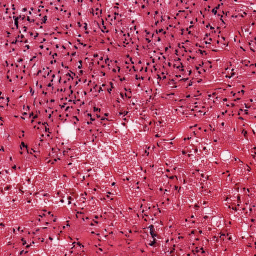

In [277]:
transforms.ToPILImage()(pid_imgs[1][0)

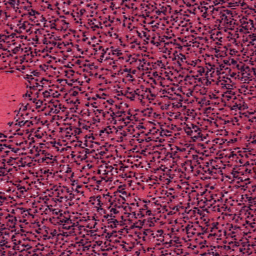

In [279]:
from PIL import Image
Image.open(pids[8])

In [291]:
pid_imgs[-4].shape

torch.Size([7, 3, 256, 256])